Replication of Figures in the Paper

In [1]:
# some temporary stuff 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Setup Dataset and Model

In [2]:
from tree_generation import GraphDataset

file_name = "dataset.txt"
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, file_name, n_examples)

Loading contents from file...


In [3]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig

cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

Figure 1: Tuned Lens

In [4]:
from interp_utils import * 
from utils import *

In [5]:
import os
import torch

def load_tuned_lenses(dir="lenses"):
    lenses = {}
    for filename in os.listdir(dir):
        if filename.endswith(".pt"):
            key = filename[:-3]  # remove the ".pt" extension
            filepath = os.path.join(dir, filename)
            lenses[key] = torch.load(filepath)
    return lenses

lenses = load_tuned_lenses()

In [6]:
# todo: outsource to another file
def logit_lens_all_probs(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    current_node = int(labels[position].split(">")[-1])
    current_neighbors = [f">{i}" for i in range(dataset.n_states)]
    # Get the logit lens for each layer's resid_post
    probs = {key: [] for key in current_neighbors}
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        for key in probs:
            key_prob = out_proj[position, dataset.tokens2idx[key]].item()
            probs[key].append(key_prob)
    # Plot data
    for key in probs:
        plt.plot(probs[key], label=key)
    plt.xlabel("Layer")
    plt.ylabel(f"Probability of Token")
    plt.title(f"Probability of Correct Token at {labels[position]}")
    plt.legend()
    plt.show()
    # Return result
    return probs

2>3,0>2,9>1,9>0,6>11,6>9,8>15,8>6,12>8,12>7,4>12,13>10,13>4,5>13,14>5|3:14>5>13>4>12>8>6>9>0>2>3


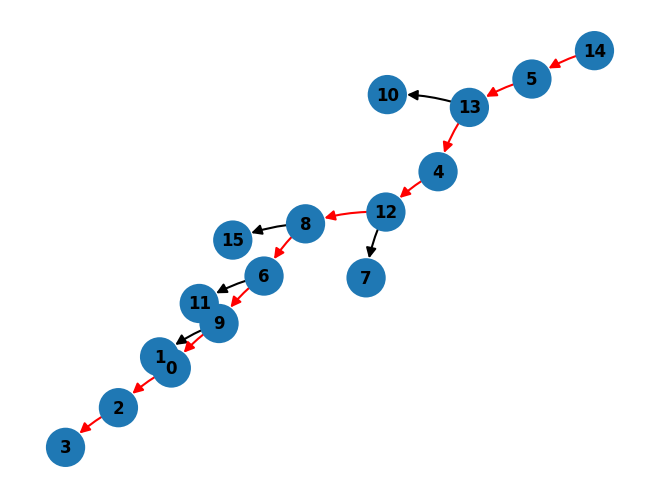

In [15]:
import random
from tree_generation import parse_example

random_seed = random.randint(0, 10000000)
test_graph = generate_example(n_states, random_seed, order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    print(pred)
    parse_example(pred)

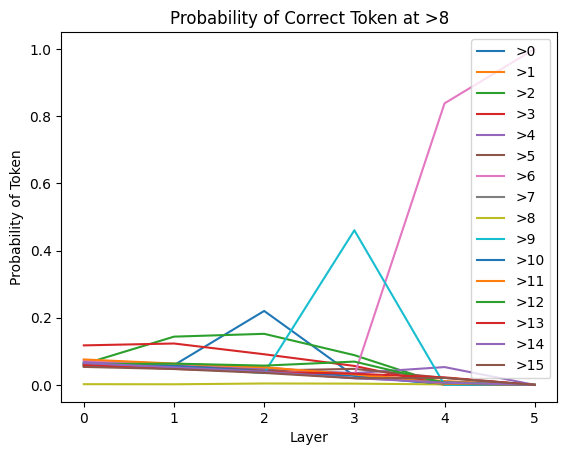

{'>0': [0.06687704473733902,
  0.05881284922361374,
  0.22015279531478882,
  0.02668783627450466,
  0.0013312320224940777,
  2.2190548065736948e-07],
 '>1': [0.05625978484749794,
  0.05807660147547722,
  0.05117734521627426,
  0.030188053846359253,
  0.011384627781808376,
  1.924560706356715e-07],
 '>2': [0.06209387257695198,
  0.14367353916168213,
  0.15207989513874054,
  0.08858443796634674,
  0.0011315752053633332,
  2.8103858085160027e-07],
 '>3': [0.11766641587018967,
  0.12326215207576752,
  0.09124623239040375,
  0.056521229445934296,
  0.0005215919227339327,
  1.202687712975603e-06],
 '>4': [0.06938469409942627,
  0.05851367488503456,
  0.047753483057022095,
  0.035223107784986496,
  0.053122665733098984,
  9.5134033983868e-08],
 '>5': [0.058487553149461746,
  0.05682407319545746,
  0.04277041554450989,
  0.04773670434951782,
  0.02085891366004944,
  1.1980776370990043e-08],
 '>6': [0.07359912991523743,
  0.06230558827519417,
  0.05301371589303017,
  0.028619619086384773,
  0.8

In [17]:
logit_lens_all_probs(pred, model, dataset, 52, lenses=lenses)